# setup

In [1]:
import torch, torchtext
from torchtext.functional import to_tensor
from torchtext.transforms import SentencePieceTokenizer
xlmr_base = torchtext.models.XLMR_BASE_ENCODER
model = xlmr_base.get_model()
transform = xlmr_base.transform()
input_batch = ["Hello world", "How are you!"]
model_input = to_tensor(transform(input_batch), padding_value=1)
output = model(model_input)
output.shape

torch.Size([2, 6, 768])

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm

from models import TextClassificationModel, zip_ssl
from datasets import AGNEWS
from utils import train, eval, acc, nomean

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
EPOCHS = 30
LR = 1e-3
BATCH_SIZE = 2048
EMBED_DIM = 64

In [5]:
criterion = nn.MSELoss()
LR=1e-5

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
# from utils import train

# Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.to(device)

# Define the optimizer for the whole model (both RoBERTa and the classification head)
optimizer = optim.AdamW(list(roberta_model.parameters()), lr=LR)

# Function to get RoBERTa embeddings for a list of sentences
def model(sentences):
    # Tokenize the sentences
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the device

    # Get the embeddings (without using torch.no_grad())
    outputs = roberta_model(**inputs, output_hidden_states=True)
    del inputs
    torch.cuda.empty_cache()
    embeddings = outputs.hidden_states[-1]  # Last layer embeddings

    # Average the embeddings along the max_sequence_length dimension
    embeddings_avg = embeddings.mean(dim=1)

    return embeddings_avg

# Assuming you have defined the AGNEWS class and its methods correctly
ds = AGNEWS()
BATCH_SIZE = 16
train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE, ssl=True)


/home/josegfer/miniconda3/envs/jiang2023low/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from torch.functional import F

def pearson(delta, ncd):
    vx = delta - torch.mean(delta)
    vy = ncd - torch.mean(ncd)

    return F.cosine_similarity(vx, vy, dim = 0)

In [8]:
def train(model, loader, criterion, optimizer, ssl = False):
    cost = 0
    corr = 0
    log = []
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(loader)):
        if ssl:
            btsz = len(offsets) // 2
            h = model(label)
            delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
            # print(idx, delta.mean())
            loss = criterion(delta, ncd)
        else:
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)

        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        log.append([loss.item(), pearson(delta, ncd).detach().cpu(), delta.mean().detach().cpu()])
        cost += loss.item()
        # corr += pearson(delta, ncd).detach().cpu()
    # return cost / loader.dataset.__len__(), corr / loader.__len__(), log
    return cost / loader.dataset.__len__(), log

# combo

In [9]:
# for _ in range(EPOCHS):
#     loss_train, log = train(model, train_loader, criterion, optimizer, ssl = True)

#     log = np.array(log)
#     fig, axes = plt.subplots(2, 3, figsize = (12, 10))
#     axes[0, 0].plot(log[:, 0]);
#     axes[0, 1].plot(log[:, 1]);
#     axes[0, 2].plot(log[:, 2]);

#     print(loss_train)

#     D_train = torch.empty(size = [0])
#     D_val = torch.empty(size = [0])
#     D_test = torch.empty(size = [0])
#     NCD_train = torch.empty(size = [0])
#     NCD_val = torch.empty(size = [0])
#     NCD_test = torch.empty(size = [0])

#     H_train = torch.empty(size = [0])
#     H_val = torch.empty(size = [0])
#     H_test = torch.empty(size = [0])
#     y_train = torch.empty(size = [0])
#     y_val = torch.empty(size = [0])
#     y_test = torch.empty(size = [0])

#     with torch.no_grad():
#         for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(train_loader)):
#             btsz = len(offsets) // 2
#             h = model(label)
#             delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
#             D_train = torch.cat((D_train, delta.cpu()))
#             NCD_train = torch.cat((NCD_train, ncd.cpu()))

#             H_train = torch.cat((H_train, h.cpu()))
#             y_train = torch.cat((y_train, classes.cpu()))

#         for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(val_loader)):
#             btsz = len(offsets) // 2
#             h = model(label)
#             delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
#             D_val = torch.cat((D_val, delta.cpu()))
#             NCD_val = torch.cat((NCD_val, ncd.cpu()))

#             H_val = torch.cat((H_val, h.cpu()))
#             y_val = torch.cat((y_val, classes.cpu()))

#         for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(test_loader)):
#             btsz = len(offsets) // 2
#             h = model(label)
#             delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
#             D_test = torch.cat((D_test, delta.cpu()))
#             NCD_test = torch.cat((NCD_test, ncd.cpu()))

#             H_test = torch.cat((H_test, h.cpu()))
#             y_test = torch.cat((y_test, classes.cpu()))

#     axes[1, 0].scatter(D_train, NCD_train);
#     axes[1, 1].scatter(D_val, NCD_val);
#     axes[1, 2].scatter(D_test, NCD_test);
#     plt.show()

#     print(pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test))

#     neigh = KNeighborsClassifier(n_neighbors = 2)
#     neigh.fit(H_train, y_train);

#     print(neigh.score(H_val, y_val), neigh.score(H_test, y_test))

#     train_loader = ds.repair(BATCH_SIZE)

# separado

40it [00:06,  6.01it/s]

7125it [18:31,  6.41it/s]


3.647472509070819e-05

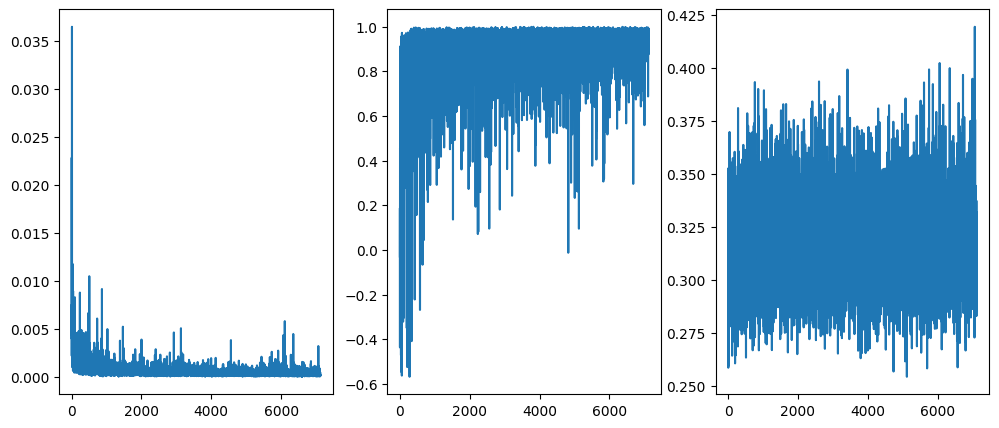

In [10]:
loss_train, log = train(model, train_loader, criterion, optimizer, ssl = True)

log = np.array(log)
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].plot(log[:, 0]);
axes[1].plot(log[:, 1]);
axes[2].plot(log[:, 2]);
loss_train

7125it [10:58, 10.82it/s]
375it [00:20, 18.39it/s]
475it [00:26, 17.62it/s]


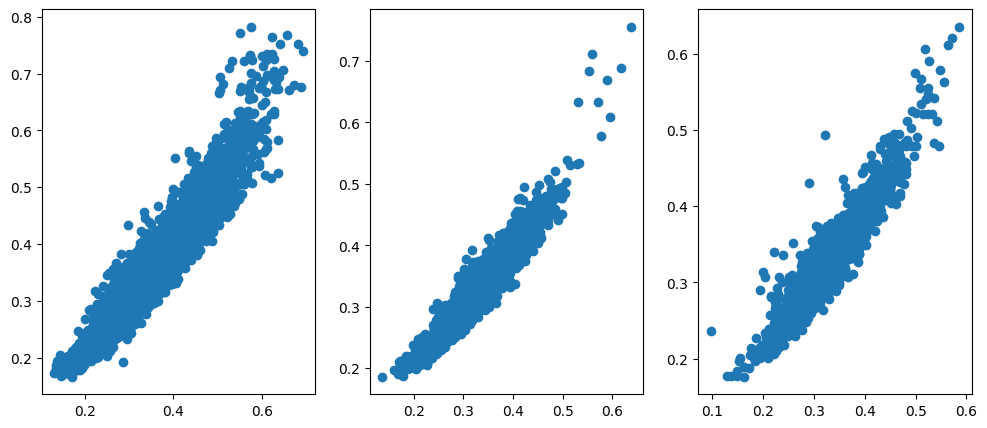

(tensor(0.9472), tensor(0.9459), tensor(0.9376))

In [11]:
D_train = torch.empty(size = [0])
D_val = torch.empty(size = [0])
D_test = torch.empty(size = [0])
NCD_train = torch.empty(size = [0])
NCD_val = torch.empty(size = [0])
NCD_test = torch.empty(size = [0])

H_train = torch.empty(size = [0])
H_val = torch.empty(size = [0])
H_test = torch.empty(size = [0])
y_train = torch.empty(size = [0])
y_val = torch.empty(size = [0])
y_test = torch.empty(size = [0])

with torch.no_grad():
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(train_loader)):
        btsz = len(offsets) // 2
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_train = torch.cat((D_train, delta.cpu()))
        NCD_train = torch.cat((NCD_train, ncd.cpu()))

        H_train = torch.cat((H_train, h.cpu()))
        y_train = torch.cat((y_train, classes.cpu()))

    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(val_loader)):
        btsz = len(offsets) // 2
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_val = torch.cat((D_val, delta.cpu()))
        NCD_val = torch.cat((NCD_val, ncd.cpu()))

        H_val = torch.cat((H_val, h.cpu()))
        y_val = torch.cat((y_val, classes.cpu()))

    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(test_loader)):
        btsz = len(offsets) // 2
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_test = torch.cat((D_test, delta.cpu()))
        NCD_test = torch.cat((NCD_test, ncd.cpu()))

        H_test = torch.cat((H_test, h.cpu()))
        y_test = torch.cat((y_test, classes.cpu()))

fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);
plt.show()

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

# clf

In [13]:
neigh = KNeighborsClassifier(n_neighbors = 2)
neigh.fit(H_train / 10, y_train);
neigh.score(H_val / 10, y_val), neigh.score(H_test / 10, y_test)

(0.8175, 0.8098684210526316)

# debug

In [23]:
import gzip

In [ ]:
with torch.no_grad():
    for x1 in label:
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_test = torch.cat((D_test, delta.cpu()))
        NCD_test = torch.cat((NCD_test, ncd.cpu()))

        H_test = torch.cat((H_test, h.cpu()))
        y_test = torch.cat((y_test, classes.cpu()))
    break

In [41]:
with torch.no_grad():
    for idx, (label, text, offsets, classes, ncd) in (enumerate(test_loader)):
        h = model(label)
        break

In [42]:
with torch.no_grad():
    for ii, x1 in enumerate(label):
        Cx1 = len(gzip.compress(x1.encode()))
        distance_from_x1 = []
        delta_x1 = []
        for idx2, (label2, text2, offsets2, classes2, ncd2) in tqdm(enumerate(train_loader)):
            h2 = model(label2)
            for jj, x2 in enumerate(label2):
                Cx2 = len(gzip.compress(x2.encode()))
                x1x2 = ''.join([x1, x2])
                Cx1x2 = len(gzip.compress(x1x2.encode()))
                ncd_paper = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
                distance_from_x1.append(ncd_paper)
                delta_x1.append(F.pairwise_distance(h[ii, :], h2[jj, :]).cpu())
        break

7125it [06:12, 19.11it/s]


In [43]:
distance_from_x1

[0.795,
 0.7014925373134329,
 0.7151898734177216,
 0.6865671641791045,
 0.7951219512195122,
 0.8181818181818182,
 0.7302631578947368,
 0.8161434977578476,
 0.7152317880794702,
 0.7122302158273381,
 0.7328767123287672,
 0.75,
 0.7484662576687117,
 0.8066037735849056,
 0.7513513513513513,
 0.7254901960784313,
 0.7423312883435583,
 0.7142857142857143,
 0.7637362637362637,
 0.7587939698492462,
 0.7058823529411765,
 0.7990430622009569,
 0.8481481481481481,
 0.7664670658682635,
 0.8243243243243243,
 0.74375,
 0.7469135802469136,
 0.8551236749116607,
 0.7514792899408284,
 0.7132352941176471,
 0.7625,
 0.7836538461538461,
 0.7267080745341615,
 0.8054298642533937,
 0.8053097345132744,
 0.8538205980066446,
 0.7736842105263158,
 0.7569060773480663,
 0.7014925373134329,
 0.7624309392265194,
 0.7345679012345679,
 0.7671957671957672,
 0.7611111111111111,
 0.8369565217391305,
 0.8539325842696629,
 0.7315436241610739,
 0.7777777777777778,
 0.7734806629834254,
 0.7666666666666667,
 0.7613636363636364,


In [49]:
delta_x1 = np.array(delta_x1) / 10

In [55]:
distance_from_x1 = np.array(distance_from_x1)

tensor(0.8564, dtype=torch.float64)

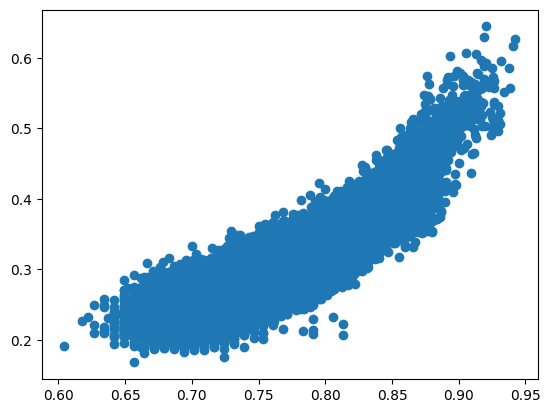

In [57]:
plt.scatter(distance_from_x1, delta_x1);
pearson(torch.tensor(distance_from_x1), torch.tensor(delta_x1))